In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import optuna

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.api as sm

**Effective Federal Funds Rate (EFFR) Modelling Using ARIMA/ SARIMA/ ARIMAX:**

Interest rates play a crucial role in financial markets, influencing borrowing costs, investments, and economic growth. The Effective Federal Funds Rate (EFFR) is a key benchmark that reflects the cost of overnight lending between banks and serves as a foundation for setting broader loan and mortgage interest rates.

This project focuses on evaluating the performance of different time series models in capturing historical EFFR trends. We explore three statistical modeling approaches:

- ARIMA (AutoRegressive Integrated Moving Average): Captures non-seasonal trends in interest rates.
- SARIMA (Seasonal ARIMA): Accounts for seasonal patterns in rate fluctuations.
- ARIMAX (ARIMA with Exogenous Variables): Incorporates macroeconomic factors like inflation and unemployment rates to enhance prediction accuracy.

By analyzing historical data from 2007 to 2017, this project provides insights into the strengths and limitations of different time series forecasting models in capturing EFFR behavior. 

## EDA

In [2]:
# Load the dataset
file_path = "../data/interest_rates.csv"
df = pd.read_csv(file_path)
df.head()

,Year,Month,Day,Federal Funds Target Rate,Federal Funds Upper Target,Federal Funds Lower Target,Effective Federal Funds Rate,Real GDP (Percent Change),Unemployment Rate,Inflation Rate
0,1954,7,1,NaN,NaN,NaN,0.80,4.6,5.8,NaN
1,1954,8,1,NaN,NaN,NaN,1.22,NaN,6.0,NaN
2,1954,9,1,NaN,NaN,NaN,1.06,NaN,6.1,NaN
3,1954,10,1,NaN,NaN,NaN,0.85,8.0,5.7,NaN
4,1954,11,1,NaN,NaN,NaN,0.83,NaN,5.3,NaN


In [3]:
# Convert Year, Month, Day to datetime
df['Date'] = pd.to_datetime(df[['Year', 'Month', 'Day']])
df.set_index('Date', inplace=True)

In [4]:
df.shape

(904, 10)

In [5]:
# filtered_df = df[(df["Year"] >= 2007)]
# filtered_df.iloc[9:20]

In [6]:
# filtered_df = df[(df["Effective Federal Funds Rate"].isna()) & (df["Year"] >= 2007)]
# filtered_df

In [7]:
df.isna().sum()

Year                              0
Month                             0
Day                               0
Federal Funds Target Rate       442
Federal Funds Upper Target      801
Federal Funds Lower Target      801
Effective Federal Funds Rate    152
Real GDP (Percent Change)       654
Unemployment Rate               152
Inflation Rate                  194
dtype: int64

In [8]:
# Select interest rate column (Effective Federal Funds Rate)
df = df[['Effective Federal Funds Rate', 'Inflation Rate', 'Unemployment Rate']].dropna()
df.rename(columns={'Effective Federal Funds Rate': 'Interest_Rate',
                  'Inflation Rate': 'Inflation_Rate',
                  'Unemployment Rate': 'Unemployment_Rate'}, inplace=True)

In [9]:
# Summary statistics
print("Basic Statistics:")
print(df.describe())

Basic Statistics:
       Interest_Rate  Inflation_Rate  Unemployment_Rate
count     710.000000      710.000000         710.000000
mean        5.064239        3.733380           6.068873
std         3.654701        2.573637           1.561392
min         0.070000        0.600000           3.400000
25%         2.555000        2.000000           5.000000
50%         4.900000        2.800000           5.700000
75%         6.790000        4.700000           7.100000
max        19.100000       13.600000          10.800000


## Visualise Data

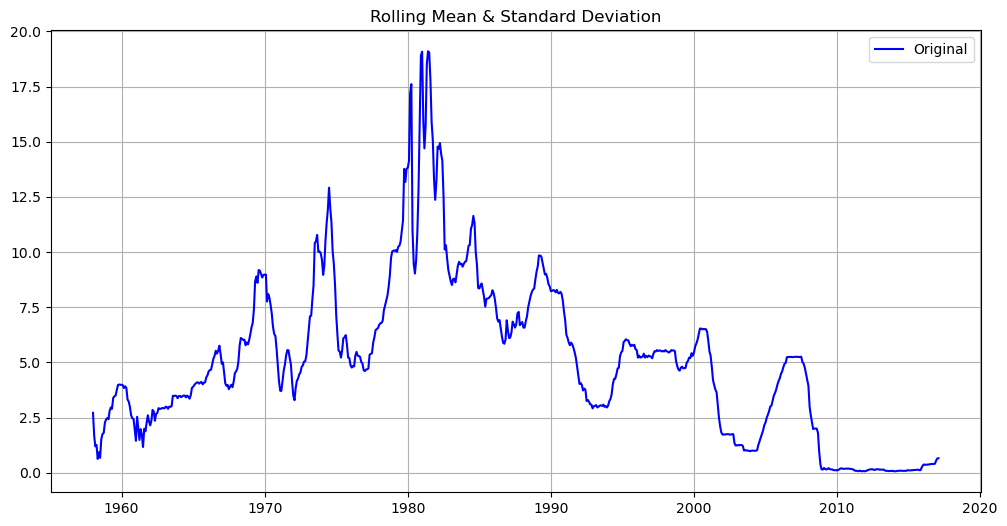

In [10]:
# All data
plt.figure(figsize=(12,6))
plt.plot(df.index, df['Interest_Rate'], label='Original', color='blue')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.grid()
plt.show()

In [11]:
# Filter data for the last 10 years
df_10y = df[df.index >= df.index.max() - pd.DateOffset(years=10)]

In [12]:
df_10y.shape

(121, 3)

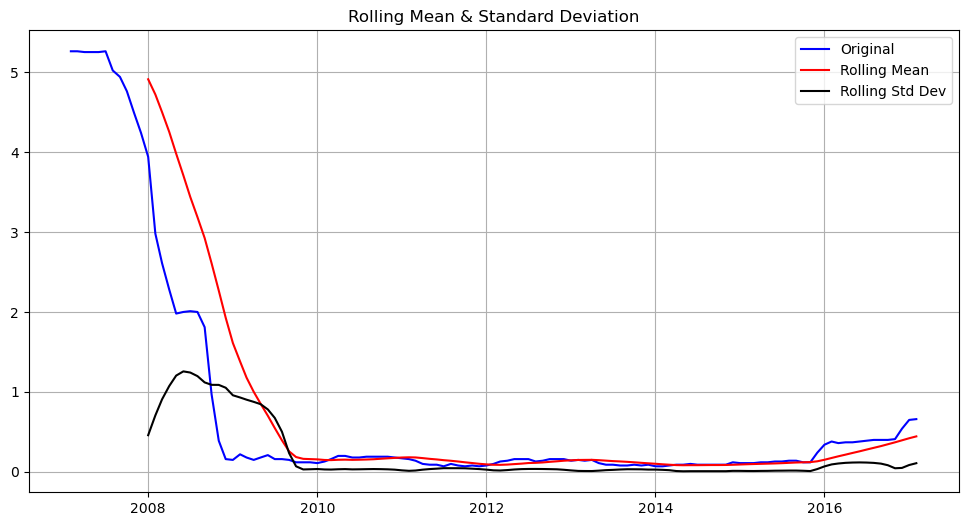

In [13]:
# Rolling statistics
rolling_mean = df_10y['Interest_Rate'].rolling(window=12).mean()
rolling_std = df_10y['Interest_Rate'].rolling(window=12).std()

plt.figure(figsize=(12,6))
plt.plot(df_10y.index, df_10y['Interest_Rate'], label='Original', color='blue')
plt.plot(df_10y.index, rolling_mean, label='Rolling Mean', color='red')
plt.plot(df_10y.index, rolling_std, label='Rolling Std Dev', color='black')
plt.title('Rolling Mean & Standard Deviation')
plt.legend()
plt.grid()
plt.show()

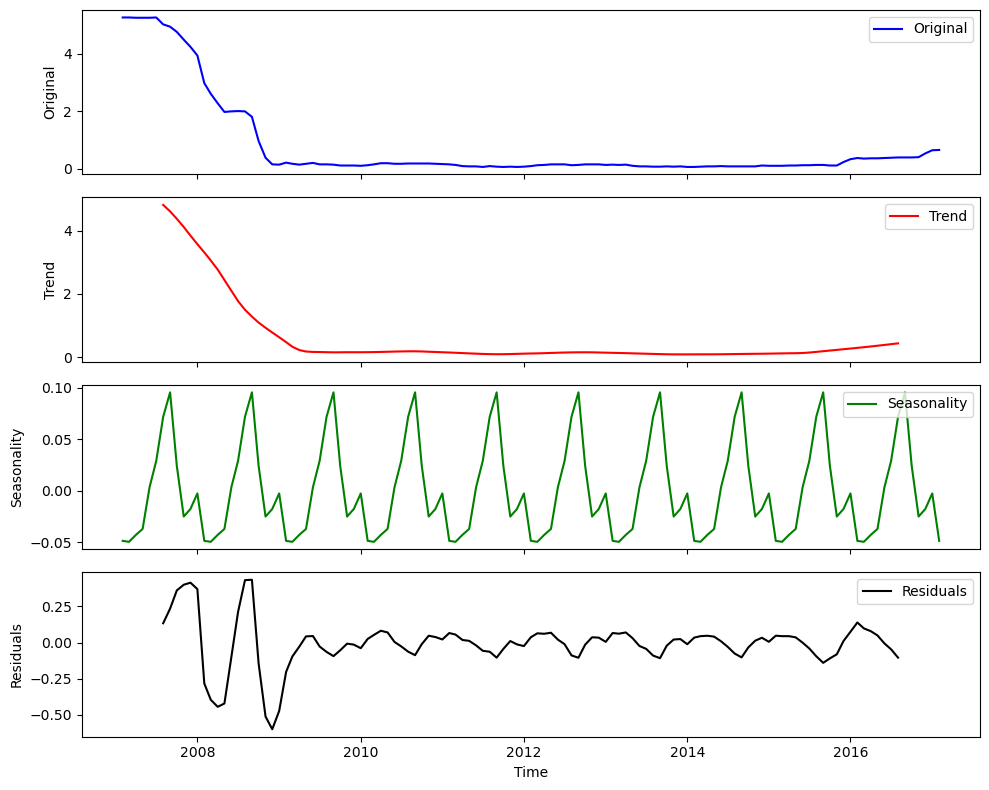

In [14]:
# seasonality component for period = 12 has a clear and stable repeating patter
# yearly seasonality (e.g., monthly data with a yearly cycle).
decompose_result = seasonal_decompose(df_10y['Interest_Rate'], model='additive', period=12)

# Plot the decomposed components
fig, axes = plt.subplots(4, 1, figsize=(10, 8), sharex=True)

# Original Series
axes[0].plot(df_10y['Interest_Rate'], label='Original', color='blue')
axes[0].set_ylabel('Original')
axes[0].legend()

# Trend
axes[1].plot(decompose_result.trend, label='Trend', color='red')
axes[1].set_ylabel('Trend')
axes[1].legend()

# Seasonality
axes[2].plot(decompose_result.seasonal, label='Seasonality', color='green')
axes[2].set_ylabel('Seasonality')
axes[2].legend()

# Residuals
axes[3].plot(decompose_result.resid, label='Residuals', color='black')
axes[3].set_ylabel('Residuals')
axes[3].legend()

plt.xlabel('Time')
plt.tight_layout()
plt.show()

Trend Component (Red)
-  There is a strong downward trend from 2007 to 2009, indicating a significant decline in interest rates, likely due to the 2008 Global Financial Crisis.
- From 2009 to 2015, the trend remains relatively flat, suggesting a period of stable interest rates.
- Around 2016–2017, there is a slight upward movement, reflecting the gradual rate hikes by the Federal Reserve.

Seasonality Component (Green)
- The seasonal component shows a consistent repeating cycle.

Residual Component (Black)
- The residuals appear random and do not show a strong pattern, indicating that most of the trends and seasonality have been captured by decomposition.
- However, there are larger fluctuations during the 2007–2009 period, likely due to financial instability.

## Check Global Stationarity
Checking for stationarity is crucial in time series forecasting because ARIMA models assume that the underlying data has a constant mean, variance, and autocorrelation over time. A non-stationary series may exhibit trends or seasonality, leading to inaccurate predictions. If the data is non-stationary, we apply differencing (the "d" in ARIMA) to transform it into a stationary series. Stationarity can be detected using methods like the Augmented Dickey-Fuller (ADF) test.

In [15]:
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] > 0.05:
        print("Series is non-stationary. Differencing may be required.")
    else:
        print("Series is stationary.")

adf_test(df_10y['Interest_Rate'])


ADF Statistic: -4.438230941264
p-value: 0.00025385085336906656
Series is stationary.


## Autocorrelation
Autocorrelation measures how a time series is correlated with lagged versions of itself. It helps in identifying patterns, trends, and seasonality in the data. In ARIMA modeling, autocorrelation functions (ACF) and partial autocorrelation functions (PACF) are used to determine the optimal parameters for the AR (Auto-Regressive) and MA (Moving Average) components.

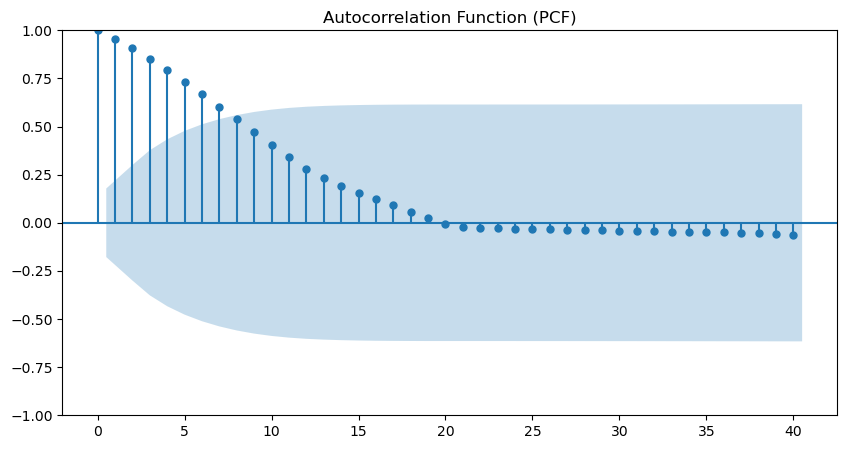

In [16]:
# Plot ACF 
fig, ax = plt.subplots(figsize=(10,5))
sm.graphics.tsa.plot_acf(df_10y['Interest_Rate'].dropna(), lags=40, ax=ax)
plt.title("Autocorrelation Function (PCF)")
plt.show()

- No clear seasonal spikes at lag 12, 24, etc.
- If seasonality were strong, we'd see repeating spikes at multiples of 12 (monthly data) or 4 (quarterly data).

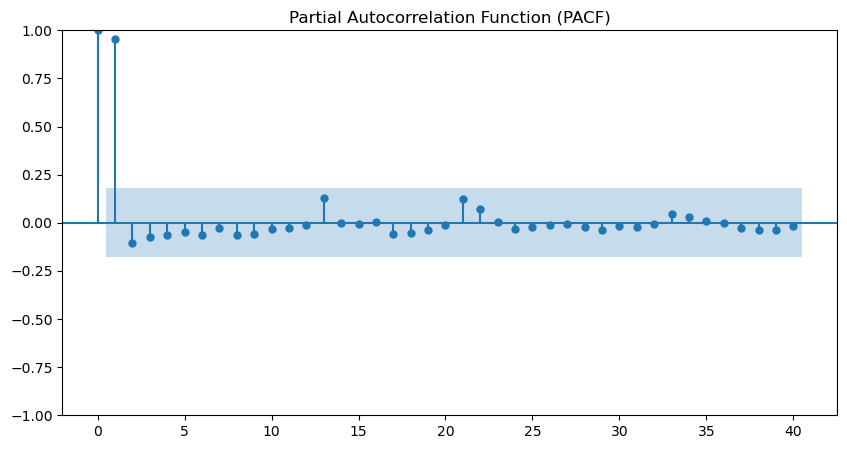

In [17]:
# Plot PACF
fig, ax = plt.subplots(figsize=(10,5))
sm.graphics.tsa.plot_pacf(df_10y['Interest_Rate'].dropna(), lags=40, ax=ax, method='ywm')
plt.title("Partial Autocorrelation Function (PACF)")
plt.show()

- The ACF plot shows a gradual decline instead of a sharp cutoff (q = 0 or 1).
- The PACF plot cuts off sharply after lag 1 (p=1)
- ADF test confirms stationarity (p-value < 0.05), set d=0
- Try ARIMA(1,0,1) 

## Split Datset

In [18]:
# Define split size (80% train, 20% test)
split_size = int(len(df_10y) * 0.8)

# Train and test split
df_train = df_10y[:split_size]  
df_test = df_10y[split_size:]   

y_train = df_train['Interest_Rate']
y_test = df_test['Interest_Rate']

exog_train = df_train[['Inflation_Rate', 'Unemployment_Rate']]
exog_test = df_test[['Inflation_Rate', 'Unemployment_Rate']]

print("Training Data Size:", len(df_train))
print("Testing Data Size:", len(df_test))

Training Data Size: 96
Testing Data Size: 25


## ARIMA Model (Base model)

(p, d, q) → Standard ARIMA components:

- p = AR (Auto-Regressive) Order (Check PACF)
- d = Differencing Order (Check ADF Test)
- q = MA (Moving Average) Order (Check ACF)

In [19]:
# Define ARIMA model based on ACF/PACF results 
model = ARIMA(y_train, order=(1,0,1)) 
model_fit_arima = model.fit()

# Model Summary
print(model_fit_arima.summary())

                               SARIMAX Results                                
Dep. Variable:          Interest_Rate   No. Observations:                   96
Model:                 ARIMA(1, 0, 1)   Log Likelihood                  52.706
Date:                Sun, 16 Mar 2025   AIC                            -97.412
Time:                        14:24:17   BIC                            -87.154
Sample:                    02-01-2007   HQIC                           -93.265
                         - 01-01-2015                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4055      2.694      0.893      0.372      -2.874       7.685
ar.L1          0.9963      0.018     55.455      0.000       0.961       1.032
ma.L1          0.5822      0.060      9.686      0.0

/Users/chushinying/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chushinying/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chushinying/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [20]:
# Forecast the next values (same length as test set)
forecast_steps = len(y_test)
forecast_arima = model_fit_arima.forecast(steps=forecast_steps)
y_pred_arima = forecast_arima.to_frame(name="Predicted")

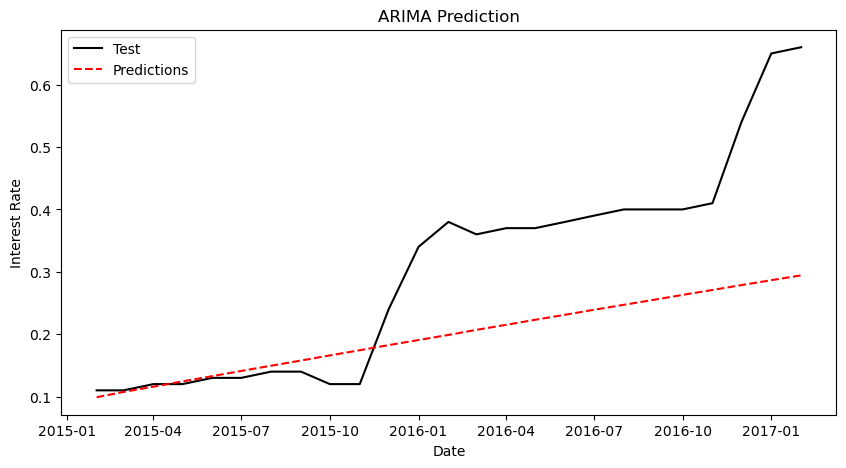

In [21]:
# Plot test and predictions
plt.figure(figsize=(10,5))
plt.plot(y_test, label="Test", color='black')
plt.plot(y_pred_arima, label="Predictions", color='red', linestyle="dashed")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Interest Rate")
plt.title("ARIMA Prediction")
plt.legend()
plt.show()

In [22]:
# Compute error metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_arima))
mae = mean_absolute_error(y_test, y_pred_arima)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 0.1542
MAE: 0.1148


## SARIMA Model

In [32]:
# Tuning SARIMA with Optuna to Minimize RMSE:
def objective(trial):
    # Suggest values for SARIMA parameters
    p = trial.suggest_int("p", 0, 4)
    q = trial.suggest_int("q", 0, 4)
    P = trial.suggest_int("P", 0, 3)
    Q = trial.suggest_int("Q", 0, 3)
    s = 12  
    
    try:
        # Fit SARIMA model
        model = sm.tsa.statespace.SARIMAX(df_train,
                                          order=(p, 0, q),
                                          seasonal_order=(P, 1, Q, s),
                                          enforce_stationarity=False,
                                          enforce_invertibility=False)
        results = model.fit(disp=False)

        # Forecast on test set
        forecast = results.get_forecast(steps=len(df_test))
        df_pred = forecast.predicted_mean.to_frame(name="Predicted")
        df_pred.index = df_test.index

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(df_test, df_pred))
        return rmse  #

    except:
        return float("inf")  

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

best_params = study.best_params
print(f"Best Parameters: {best_params}")

[I 2025-03-16 13:07:51,379] A new study created in memory with name: no-name-6bc6ef81-0d37-4fae-9371-d902bf615a65
/Users/chushinying/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
[I 2025-03-16 13:07:51,397] Trial 0 finished with value: inf and parameters: {'p': 2, 'q': 3, 'P': 0, 'Q': 0}. Best is trial 0 with value: inf.
/Users/chushinying/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
[I 2025-03-16 13:07:51,401] Trial 1 finished with value: inf and parameters: {'p': 2, 'q': 4, 'P': 3, 'Q': 1}. Best is trial 0 with value: inf.
/Users/chushinying/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inf

/Users/chushinying/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
[I 2025-03-16 13:07:51,660] Trial 23 finished with value: inf and parameters: {'p': 0, 'q': 3, 'P': 0, 'Q': 3}. Best is trial 0 with value: inf.
/Users/chushinying/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
[I 2025-03-16 13:07:51,679] Trial 24 finished with value: inf and parameters: {'p': 2, 'q': 2, 'P': 0, 'Q': 1}. Best is trial 0 with value: inf.
/Users/chushinying/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
[I 2025-03-16 13:07:51,698] Trial 25 finished w

/Users/chushinying/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
[I 2025-03-16 13:07:52,078] Trial 46 finished with value: inf and parameters: {'p': 1, 'q': 2, 'P': 3, 'Q': 1}. Best is trial 0 with value: inf.
/Users/chushinying/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
[I 2025-03-16 13:07:52,098] Trial 47 finished with value: inf and parameters: {'p': 0, 'q': 0, 'P': 1, 'Q': 0}. Best is trial 0 with value: inf.
/Users/chushinying/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
[I 2025-03-16 13:07:52,117] Trial 48 finished w

Best Parameters: {'p': 2, 'q': 3, 'P': 0, 'Q': 0}


In [23]:
# Fit SARIMAX model on differenced data
sarimax_model = SARIMAX(
    y_train,  
    order=(2, 0, 3),  
    seasonal_order=(0, 1, 0, 12)
)

# Fit the model
sarimax_fit = sarimax_model.fit()

/Users/chushinying/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chushinying/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            6     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  2.32272D-01    |proj g|=  1.39412D+01

At iterate    5    f= -2.43780D-01    |proj g|=  8.49111D-01

At iterate   10    f= -3.83975D-01    |proj g|=  3.19523D-01

At iterate   15    f= -4.03875D-01    |proj g|=  1.98897D-01

At iterate   20    f= -4.19039D-01    |proj g|=  6.70932D-02

At iterate   25    f= -4.23413D-01    |proj g|=  4.43330D-02

At iterate   30    f= -4.25080D-01    |proj g|=  3.02914D-02

At iterate   35    f= -4.25518D-01    |proj g|=  1.64087D-02

At iterate   40    f= -4.26074D-01    |proj g|=  6.40151D-02

At iterate   45    f= -4.26281D-01    |proj g|=  4.79748D-02

At iterate   50    f= -4.28223D-01    |proj g|=  1.53142D-01

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/Users/chushinying/anaconda3/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [24]:
forecast_sarimax = sarimax_fit.forecast(steps=len(df_test))
df_pred_sarimax = forecast_sarimax.to_frame(name="Predicted")

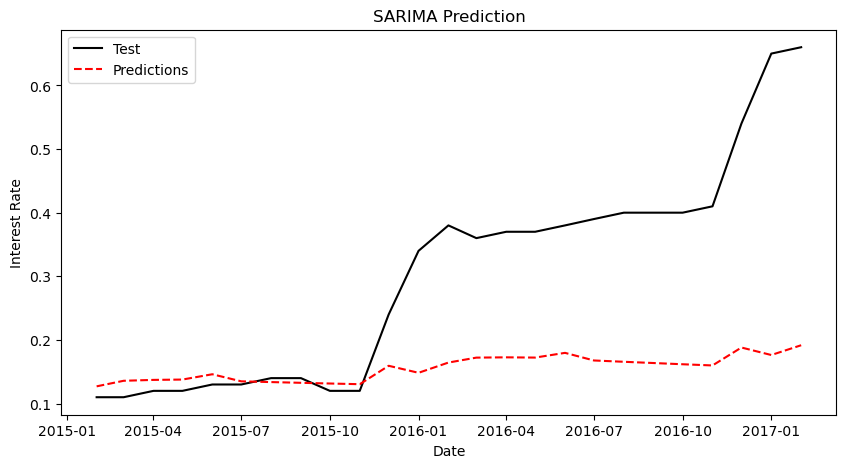

In [25]:
# Plot test and predictions
plt.figure(figsize=(10,5))
plt.plot(y_test, label="Test", color='black')
plt.plot(df_pred_sarimax, label="Predictions", color='red', linestyle="dashed")

# Labels and title
plt.xlabel("Date")
plt.ylabel("Interest Rate")
plt.title("SARIMA Prediction")
plt.legend()
plt.show()

In [27]:
# Compute error metrics
rmse = np.sqrt(mean_squared_error(y_test, df_pred_sarimax))
mae = mean_absolute_error(y_test, df_pred_sarimax)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 0.2090
MAE: 0.1552


## ARIMAX Model

In [26]:
# Auto-ARIMA to find best (p, d, q) with exogenous variable
auto_model = auto_arima(y_train, exogenous=exog_train, 
                        start_p=1, max_p=5, 
                        start_q=1, max_q=5, 
                        d=0, seasonal=False, 
                        trace=True, stepwise=True)

# Print best model parameters
print(f"Best ARIMAX order: {auto_model.order}")

Performing stepwise search to minimize aic
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-98.628, Time=0.06 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=394.184, Time=0.01 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=inf, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=inf, Time=0.03 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-112.770, Time=0.05 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=inf, Time=0.04 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-110.864, Time=0.10 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-112.387, Time=0.08 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-103.352, Time=0.06 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=inf, Time=0.05 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-108.823, Time=0.14 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=-111.717, Time=0.11 sec

Best model:  ARIMA(2,0,1)(0,0,0)[0]          
Total fit time: 0.754 seconds
Best ARIMAX order: (2, 0, 1)


In [28]:
# Fit ARIMAX Model
arimax_model = sm.tsa.statespace.SARIMAX(y_train,
                                  order=(1, 0, 1),
                                  exog=exog_train,  # Use Inflation Rate & Unemployment Rate as exogenous variable
                                  enforce_stationarity=False,
                                  enforce_invertibility=False)

/Users/chushinying/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/Users/chushinying/anaconda3/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [29]:
# Fit the model
arimax_fit = arimax_model.fit()
forecast_arimax = arimax_fit.forecast(steps=len(df_test), exog=exog_test)
y_pred_arimax = forecast_arimax.to_frame(name="Predicted")

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.99617D-01    |proj g|=  4.69384D-01

At iterate    5    f= -6.17213D-01    |proj g|=  2.10344D+00

At iterate   10    f= -6.81817D-01    |proj g|=  3.96530D-01

At iterate   15    f= -7.24633D-01    |proj g|=  4.48561D-02

At iterate   20    f= -7.24655D-01    |proj g|=  9.99454D-05

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     20     27      1     0     0   9.995D-05  -7.247D-01
  F = -0.72465544172701868     

CONVERG

 This problem is unconstrained.


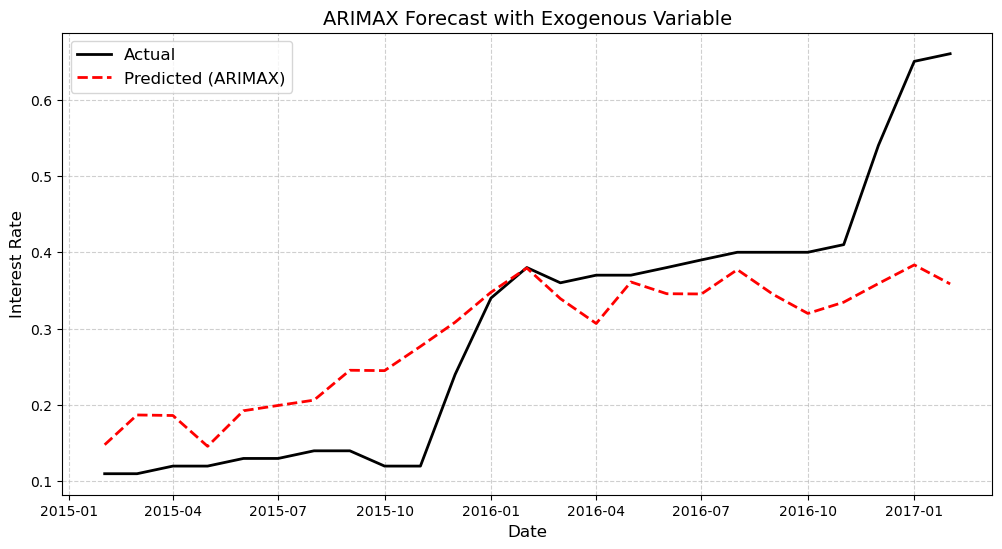

In [30]:
plt.figure(figsize=(12,6))
plt.plot(df_test["Interest_Rate"], label="Actual", color='black', linewidth=2)
plt.plot(y_pred_arimax, label="Predicted (ARIMAX)", color='red', linestyle="dashed", linewidth=2)

plt.xlabel("Date", fontsize=12)
plt.ylabel("Interest Rate", fontsize=12)
plt.title("ARIMAX Forecast with Exogenous Variable", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

In [31]:
# Compute error metrics
rmse = np.sqrt(mean_squared_error(y_test, y_pred_arimax))
mae = mean_absolute_error(y_test, y_pred_arimax)

print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

RMSE: 0.1095
MAE: 0.0809
